In [1]:
import json
import os
import cv2
from pathlib import Path
from PIL import Image, ImageOps
import pandas as pd
from pandas import json_normalize
import random
import re
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import models
from torchvision.models import resnet50
from torchvision.io import read_image
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Load the SDK
import lyft_dataset_sdk
from lyft_dataset_sdk.lyftdataset import LyftDataset, LyftDatasetExplorer, Quaternion, view_points
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, box_in_image, view_points

In [2]:
data_path = Path(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles")
json_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\data"
lyftdata = LyftDataset(data_path=data_path, json_path=json_path, verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 9.8 seconds.
Reverse indexing ...
Done reverse indexing in 2.7 seconds.


## Data Selection/Preprocessing

In [3]:
#In order to find the image files that contain our moto_anns, we must do the following:
#Accumulate the superset of Samples that contain all of our moto_annotations
def img_class_selector(class_name, box_visibility = BoxVisibility.ALL):
    """
    There wasn't a super clean way in the API to select image files that contain annotations from x class. I adapted the method they use in their .render_annotation() method.

    Returns tuples of (file_path, Box object, camera_intrinsic, sample_token, cam)
    """

    annos_class = lyftdata.sample_annotation
    class_anns = [d for d in annos_class if d["category_name"] == class_name]
    sample_class_tokens = set()
    for ann in class_anns:
        sample_class_tokens.add(ann["sample_token"])

    class_images_boxes = []
    for sample_token in sample_class_tokens:
        sample_record = lyftdata.get("sample", sample_token)
        sample_anns = sample_record["anns"]
        cams = [key for key in sample_record["data"].keys() if "CAM" in key]
        
        #We unfortunately do have to iterate through each annotation that exists within the sample_record. There typically aren't more than 20-30 or so.
        for ann in sample_anns:
            # Figure out which camera the object is fully visible in (this may return nothing)
            for cam in cams:
                path, box, camera_intrinsic = lyftdata.get_sample_data(sample_record["data"][cam], box_vis_level=box_visibility, selected_anntokens=[ann])
                if box:
                    if box[0].name == class_name:
                        class_images_boxes.append((str(path), box[0], camera_intrinsic, sample_token, cam, ann))

    return class_images_boxes

In [4]:
def crop_select_images(img_class_selector_output, output_path, output_size ,box_area_threshold = 5000):
    path, box, camera_intrinsic, sample_token, cam, ann = img_class_selector_output
    
    box_coords = view_points(box.corners(), view = camera_intrinsic, normalize=True)[:2, :]
    
    # Calculate bounding box coordinates
    x_min = np.min(box_coords[0])
    y_min = np.min(box_coords[1])
    x_max = np.max(box_coords[0])
    y_max = np.max(box_coords[1])

    # Calculate the area of the bounding box
    box_area = (x_max - x_min) * (y_max - y_min)

    if box_area > box_area_threshold:
        img = Image.open(path)
        match = re.search(r'images\\(.+)', path)

        if match:
            file_name = match.group(1)
        else:
            print("Pattern not found in the path", path)
            pass

        # Crop the image. This is our initial cropping from the full size image. It is with respect to the bounding box size using box_area_threshold.
        # Pillow uses a system of (left, upper, right, lower)
        img_cropped = img.crop((x_min, y_min, x_max, y_max))

        # Check if the directory exists, if not, create it
        Path(output_path).mkdir(parents=True, exist_ok=True)
        #Save the image
        img_cropped.save(os.path.join(output_path, "cropped_" + file_name[:-5] + "_" + ann + file_name[-5:]))

In [42]:
categories = [lyftdata.category[i]["name"] for i in range(len(lyftdata.category))]
categories

['car',
 'pedestrian',
 'animal',
 'other_vehicle',
 'bus',
 'motorcycle',
 'truck',
 'emergency_vehicle',
 'bicycle']

In [5]:
# ped_images_boxes = img_class_selector("pedestrian")
# crop_select_images(ped_images_boxes)

# categories = [lyftdata.category[i]["name"] for i in range(len(lyftdata.category))]
# for cat in categories:

#     #We can skip car because we know we aren't doing this one, plus its by far the largest and most timely.
#     if cat != "car":
#         #Obtain all of the annotations and their corresponding data via image_class_selector
#         cat_images_boxes = img_class_selector(cat)

#         #Do the actual cropping and write cropped images to disk
#         img_output_path = os.path.join(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\images", cat +"_cropped")
        
#         for i in range(len(cat_images_boxes)):
#             crop_select_images(cat_images_boxes[i], output_path=img_output_path, box_area_threshold=5000)

## Preprocess pedestrain images with additional processes like Padding and Center cropping for input into model

In [47]:
class Lyft_experimental_CustomDataset(Dataset):
    def __init__(self, cropped_images_dir, target_class_name, required_size=224):
        self.cropped_images_dir = cropped_images_dir
        self.required_size = required_size
        self.image_filenames = os.listdir(cropped_images_dir)
        self.data = []
        #Our class will ingest cropped images from all classes. We must add corresponding labels to these images.
        #The images are stored in directories wrt their class. So, we use the dir name to label the image.
        # Iterate over each subdirectory in the main directory
        for class_name in os.listdir(cropped_images_dir):
            class_dir = os.path.join(cropped_images_dir, class_name)
            if os.path.isdir(class_dir):  # Check if it's a directory
                is_target_class = class_name == target_class_name
                label = 1 if is_target_class else 0

                for filename in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, filename)
                    if os.path.isfile(file_path):  # Check if it's a file
                        self.data.append((file_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)

        # Apply dynamic transformation based on image size
        image = self.dynamic_transform(image)

        # Convert the image to tensor and normalize
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, label

    def dynamic_transform(self, img):
        img_width, img_height = img.size

        if min(img.size) < self.required_size:
            # Calculate padding
            padding_left = (self.required_size - img_width) // 2
            padding_top = (self.required_size - img_height) // 2

            # Adjust for odd total padding
            padding_right = self.required_size - img_width - padding_left
            padding_bottom = self.required_size - img_height - padding_top

            # Apply padding
            img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom), fill=0)
            
        elif min(img.size) > self.required_size:
            # Crop the image to the required size if it's larger
            img = transforms.CenterCrop(self.required_size)(img)
        # No else case needed, as no action is taken if the image is already the required size
        return img

In [48]:
cropped_images_dir = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\images\cropped_images'
dataset = Lyft_experimental_CustomDataset(cropped_images_dir, target_class_name = "pedestrian", required_size=224)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [50]:
for data in dataloader:
    print(data[0])
    print(data[1])
    # print(data[1][0])
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [49]:
for i, data in enumerate(dataloader):
    print(f"Batch {i}: Labels - {data[1]}")
    if i == 5:  # Check first 5 batches
        break

Batch 0: Labels - tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Batch 1: Labels - tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0])
Batch 2: Labels - tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0])
Batch 3: Labels - tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0])
Batch 4: Labels - tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Batch 5: Labels - tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [44]:
for i in range(10):  # Test the first 10 items
    try:
        print(dataset[i])
    except Exception as e:
        print(f"Error at index {i}: {e}")

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

## Import Pytorch models

In [51]:
model_res50 = models.resnet50(pretrained=True)
num_ftrs = model_res50.fc.in_features
print(num_ftrs)
model_res50.fc = nn.Linear(num_ftrs, 2) # Modify the last layer for binary classification

c:\Users\stern\ytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\stern\ytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2048


#### Define loss function

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_res50.parameters(), lr=0.001)

#### Check if GPU is available and move the model to GPU if it is

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_res50 = model_res50.to(device)

cuda:0


#### Train through n epochs. In each epoch, we set the model into train mode. 

In [54]:
# Number of epochs to train for
num_epochs = 10

for epoch in range(num_epochs):
    #Set training mode at beginning of each epoch in case we train on validation data within epoch with requires model.eval()
    model_res50.train()  # Set the model to training mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_res50(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)

    print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

RuntimeError: stack expects each tensor to be equal size, but got [3, 224, 224] at entry 0 and [3, 224, 238] at entry 7

In [12]:
for name, layer in model_res50.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(f"Layer: {name} | Kernel Size: {layer.kernel_size} | Output Channels: {layer.out_channels}")

Layer: conv1 | Kernel Size: (7, 7) | Output Channels: 64
Layer: layer1.0.conv1 | Kernel Size: (1, 1) | Output Channels: 64
Layer: layer1.0.conv2 | Kernel Size: (3, 3) | Output Channels: 64
Layer: layer1.0.conv3 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer1.0.downsample.0 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer1.1.conv1 | Kernel Size: (1, 1) | Output Channels: 64
Layer: layer1.1.conv2 | Kernel Size: (3, 3) | Output Channels: 64
Layer: layer1.1.conv3 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer1.2.conv1 | Kernel Size: (1, 1) | Output Channels: 64
Layer: layer1.2.conv2 | Kernel Size: (3, 3) | Output Channels: 64
Layer: layer1.2.conv3 | Kernel Size: (1, 1) | Output Channels: 256
Layer: layer2.0.conv1 | Kernel Size: (1, 1) | Output Channels: 128
Layer: layer2.0.conv2 | Kernel Size: (3, 3) | Output Channels: 128
Layer: layer2.0.conv3 | Kernel Size: (1, 1) | Output Channels: 512
Layer: layer2.0.downsample.0 | Kernel Size: (1, 1) | Output Channels: 5

In [15]:
state_dict = model_res50.state_dict()

In [19]:
[k for k in state_dict.keys()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'bn1.running_mean',
 'bn1.running_var',
 'bn1.num_batches_tracked',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.bn1.running_mean',
 'layer1.0.bn1.running_var',
 'layer1.0.bn1.num_batches_tracked',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.0.bn2.running_mean',
 'layer1.0.bn2.running_var',
 'layer1.0.bn2.num_batches_tracked',
 'layer1.0.conv3.weight',
 'layer1.0.bn3.weight',
 'layer1.0.bn3.bias',
 'layer1.0.bn3.running_mean',
 'layer1.0.bn3.running_var',
 'layer1.0.bn3.num_batches_tracked',
 'layer1.0.downsample.0.weight',
 'layer1.0.downsample.1.weight',
 'layer1.0.downsample.1.bias',
 'layer1.0.downsample.1.running_mean',
 'layer1.0.downsample.1.running_var',
 'layer1.0.downsample.1.num_batches_tracked',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.bn1.running_mean',
 'layer1.1.bn1.running_var',
 'layer1.1.bn1.num_batches_trac

tensor([[[0.5093, 0.5100, 0.4907, 0.4860, 0.4746, 0.4731, 0.4552],
         [0.5036, 0.5046, 0.5103, 0.5141, 0.5025, 0.4874, 0.4760],
         [0.5156, 0.5163, 0.5114, 0.5390, 0.5673, 0.5415, 0.5345],
         [0.5121, 0.4991, 0.4672, 0.4664, 0.4879, 0.5220, 0.5384],
         [0.4980, 0.5144, 0.4903, 0.4630, 0.4177, 0.4471, 0.5012],
         [0.4983, 0.5267, 0.5357, 0.5502, 0.5118, 0.4744, 0.4858],
         [0.4449, 0.4754, 0.4847, 0.5182, 0.5191, 0.5105, 0.4972]],

        [[0.4885, 0.5075, 0.5155, 0.5357, 0.5349, 0.5285, 0.4941],
         [0.4954, 0.5123, 0.5437, 0.5840, 0.6027, 0.5937, 0.5769],
         [0.4711, 0.4517, 0.4430, 0.4985, 0.5783, 0.6074, 0.6132],
         [0.4745, 0.4185, 0.3405, 0.2969, 0.3387, 0.4462, 0.5209],
         [0.5185, 0.5079, 0.4457, 0.3451, 0.2566, 0.3000, 0.4047],
         [0.5487, 0.5844, 0.5932, 0.5789, 0.4927, 0.4160, 0.4125],
         [0.4912, 0.5451, 0.5855, 0.6324, 0.6143, 0.5672, 0.5108]],

        [[0.4888, 0.4968, 0.5060, 0.5214, 0.5172, 0.5174, 

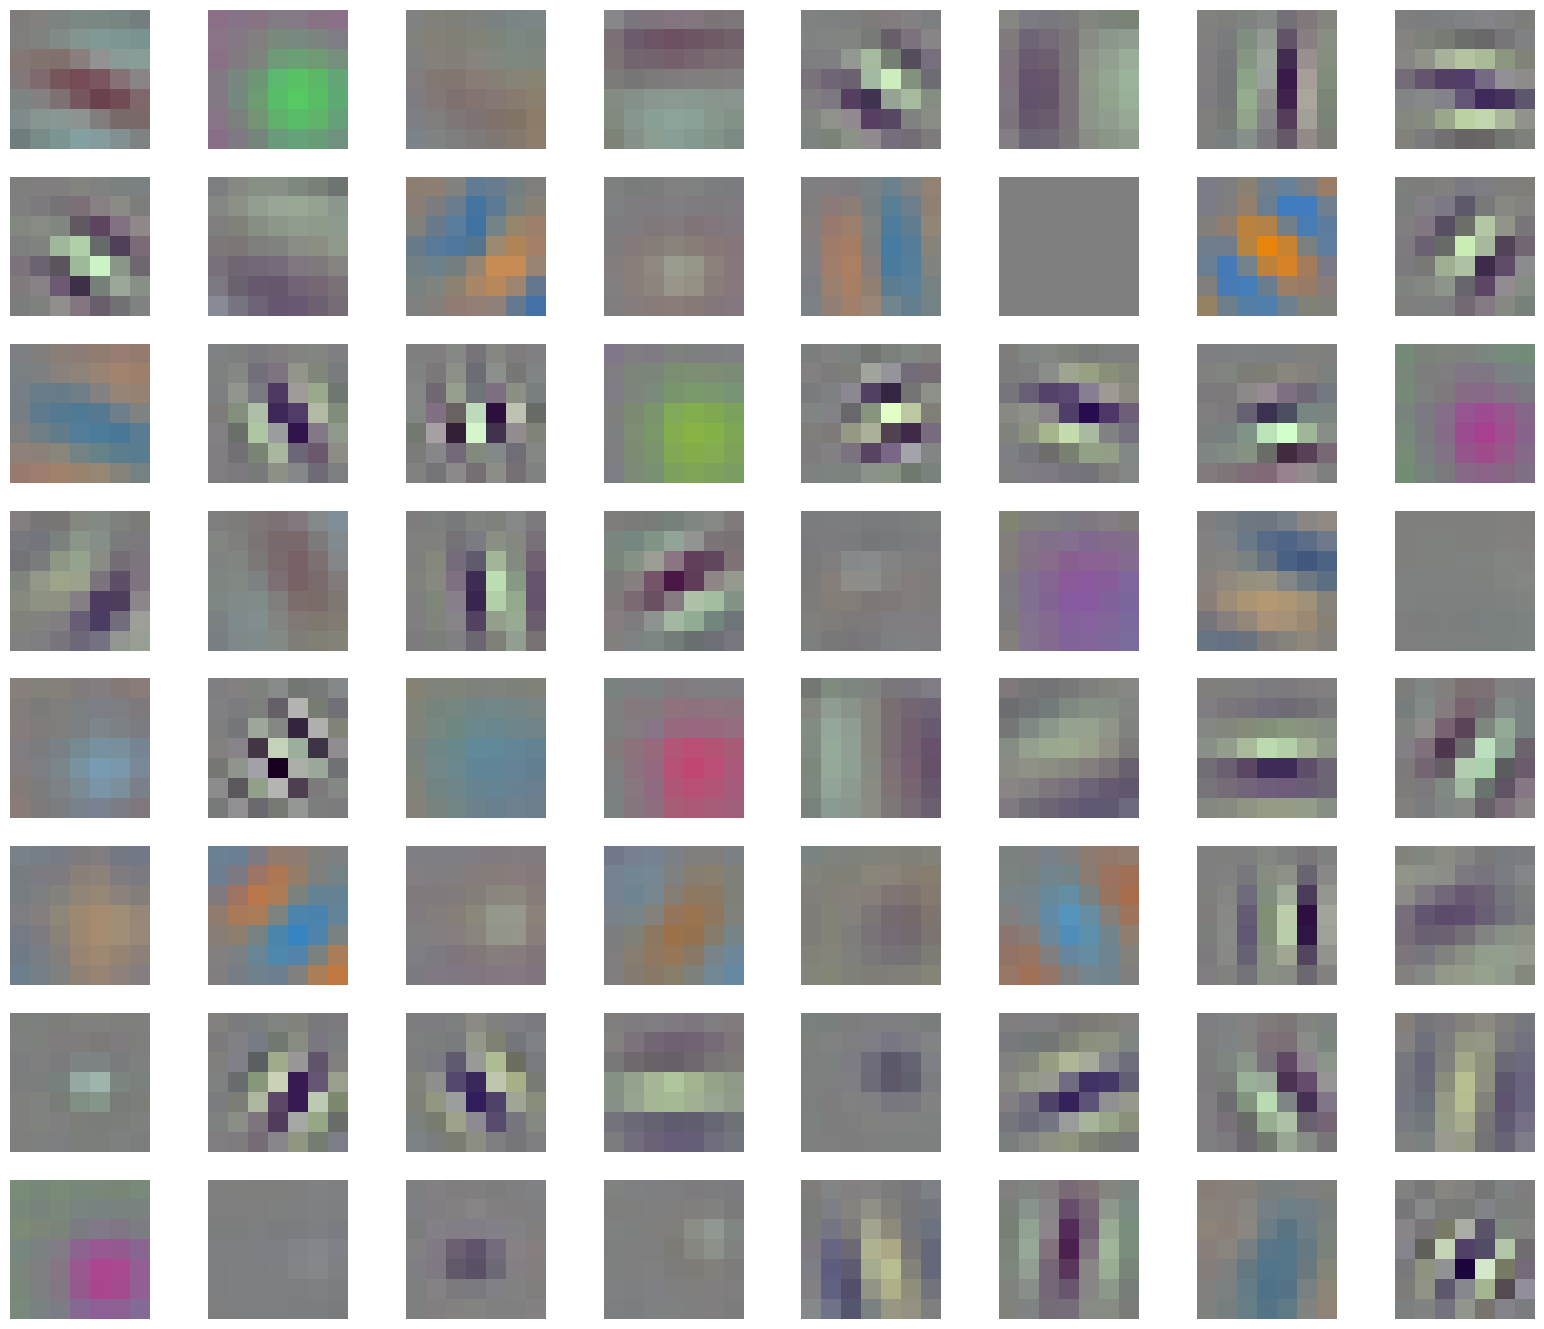

In [34]:
# Ensure it's in evaluation mode for visualization
model_res50.eval()  # This changes the model to evaluation mode

# Get the weights of the first convolutional layer
weights = model_res50.conv1.weight.data.cpu()

# Normalize the weights for better visualization
weights = (weights - weights.min()) / (weights.max() - weights.min())
print(weights[0])
print(weights[0].permute(1, 2, 0))
# Plot the first few filters
plt.figure(figsize=(20, 17))
for i in range(64):  # Let's visualize 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(weights[i].permute(1, 2, 0))  # Rearrange the dimensions
    plt.axis('off')
plt.show()

In [35]:
print(model_res50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 